# Neural Network Implementation: simulated data, without test-time Dropout

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import seaborn as sns
import pymc3 as pm
plt.style.use('seaborn')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

-----

## The model:

In [47]:
# Fit model according to specification in paper
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Implement learning rate schedule
# Adapted from examples at https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def learning_schedule(epoch):
    base_lrate = 5e-3
    gamma = 0.0001
    p = 0.25
    lrate = base_lrate * (1 + gamma*140*epoch)**(-p)
    return lrate

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
# Fit model according to specification in paper
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Implement learning rate schedule
# Adapted from examples at https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def learning_schedule(epoch):
    base_lrate = 5e-3
    gamma = 0.0001
    p = 0.25
    lrate = base_lrate * (1 + gamma*140*epoch)**(-p)
    return lrate

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
def create_no_test_dropout_model():
    # Create model
    
    # model = Sequential()
    
    # inputs
    inputs = keras.Input(shape=(1,))
    
    # Layer 1
    layer_1 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(inputs)
    dropout_1 = Dropout(0.1)(layer_1, training=False)
   
    # Layer 2
    layer_2 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_1)
    dropout_2 = Dropout(0.1)(layer_2, training=False)
   
    # Layer 3
    layer_3 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_2)
    dropout_3 = Dropout(0.1)(layer_3, training=False)
   
    # Layer 4
    layer_4 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_3)
    dropout_4 = Dropout(0.1)(layer_4, training=False)
    
    # Layer 5
    outputs = Dense(1, input_dim=24, kernel_initializer='lecun_uniform')(dropout_4)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

# Save predictions from every epoch
# Code from: https://stackoverflow.com/questions/36895627/python-keras-creating-a-callback-with-one-prediction-for-each-epoch?noredirect=1&lq=1


## Simulate the data:

In [18]:
# xs = np.linspace(-1, 1, 200)*2*np.pi
# ys = xs - np.cos(xs) + np.sin(xs)
# #ys = xs - np.cos(xs) + .2*np.sin(7*xs)
# #ys = -np.cos(xs)

# train_mask = [False if i in range(20, 40) 
#                    or i in range(80, 100) 
#                    or i in range(130, 150)
#               else True 
#               for i in range(len(xs))]
# test_mask = [not e for e in train_mask]

# xs_train, ys_train = xs[train_mask], ys[train_mask]
# xs_test, ys_test = xs[test_mask], ys[test_mask]

xs = np.linspace(-1, 1, 500)#*2*np.pi
#ys = xs - np.cos(xs) + np.sin(xs)
#ys = xs - np.cos(xs) + .2*np.sin(7*xs)
ys = -np.cos(xs)

#ys = np.linspace(-1, 1, 500)
#ys = np.array([1 for i in xs])

# train_mask = [False if i in range(20, 40) 
#                    or i in range(80, 100) 
#                    or i in range(130, 150)
#               else True 
#               for i in range(len(xs))]
train_mask = [False if i in range(200, 300)
              else True 
              for i in range(len(xs))]
test_mask = [not e for e in train_mask]

xs_train, ys_train = xs[train_mask], ys[train_mask]
xs_test, ys_test = xs[test_mask], ys[test_mask]

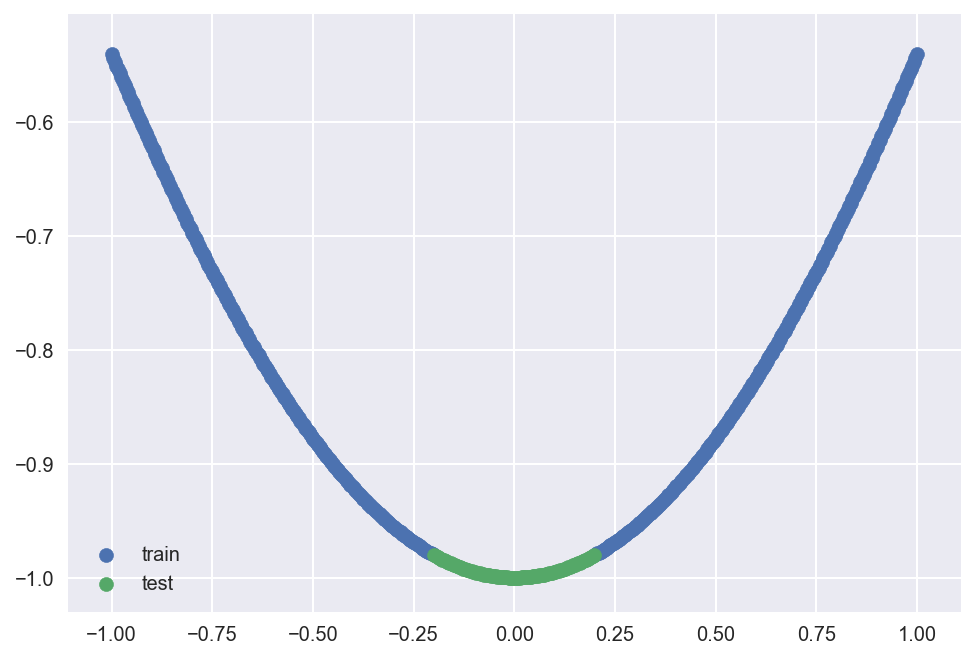

In [19]:
plt.scatter(xs_train, ys_train, label='train')
plt.scatter(xs_test, ys_test, label='test')
plt.legend();

## Train the model:

In [35]:
# Code for NBatchLogger class borrowed from https://github.com/keras-team/keras/issues/2850
# from the comment by user wenmin-wu
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display, num_xs):
        self.step = 0
        self.display = display
        self.metric_cache = {}
        self.num_xs = num_xs

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('iteration: {}... {}'.format(int(self.step/self.num_xs),
                                               metrics_log))
            self.metric_cache.clear()

class sim_prediction_history(Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self, epoch, logs={}):
        self.predhis.append(sim_model.predict(xs))

In [52]:
nepochs = 100
#predictions=sim_prediction_history()
lrate = LearningRateScheduler(learning_schedule)
#out_batch = NBatchLogger(display=140*50)
#callbacks_list = [predictions, lrate, out_batch]
callbacks_list = [lrate]

sim_model = create_no_test_dropout_model()
sim_model.fit(x=xs, y=ys, epochs=nepochs, batch_size=1, callbacks=callbacks_list, verbose=1)

## Make predictions on all data, and visualize results:

In [27]:
ys_pred = sim_model.predict(xs)
ys_pred = ys_pred[:, 0]

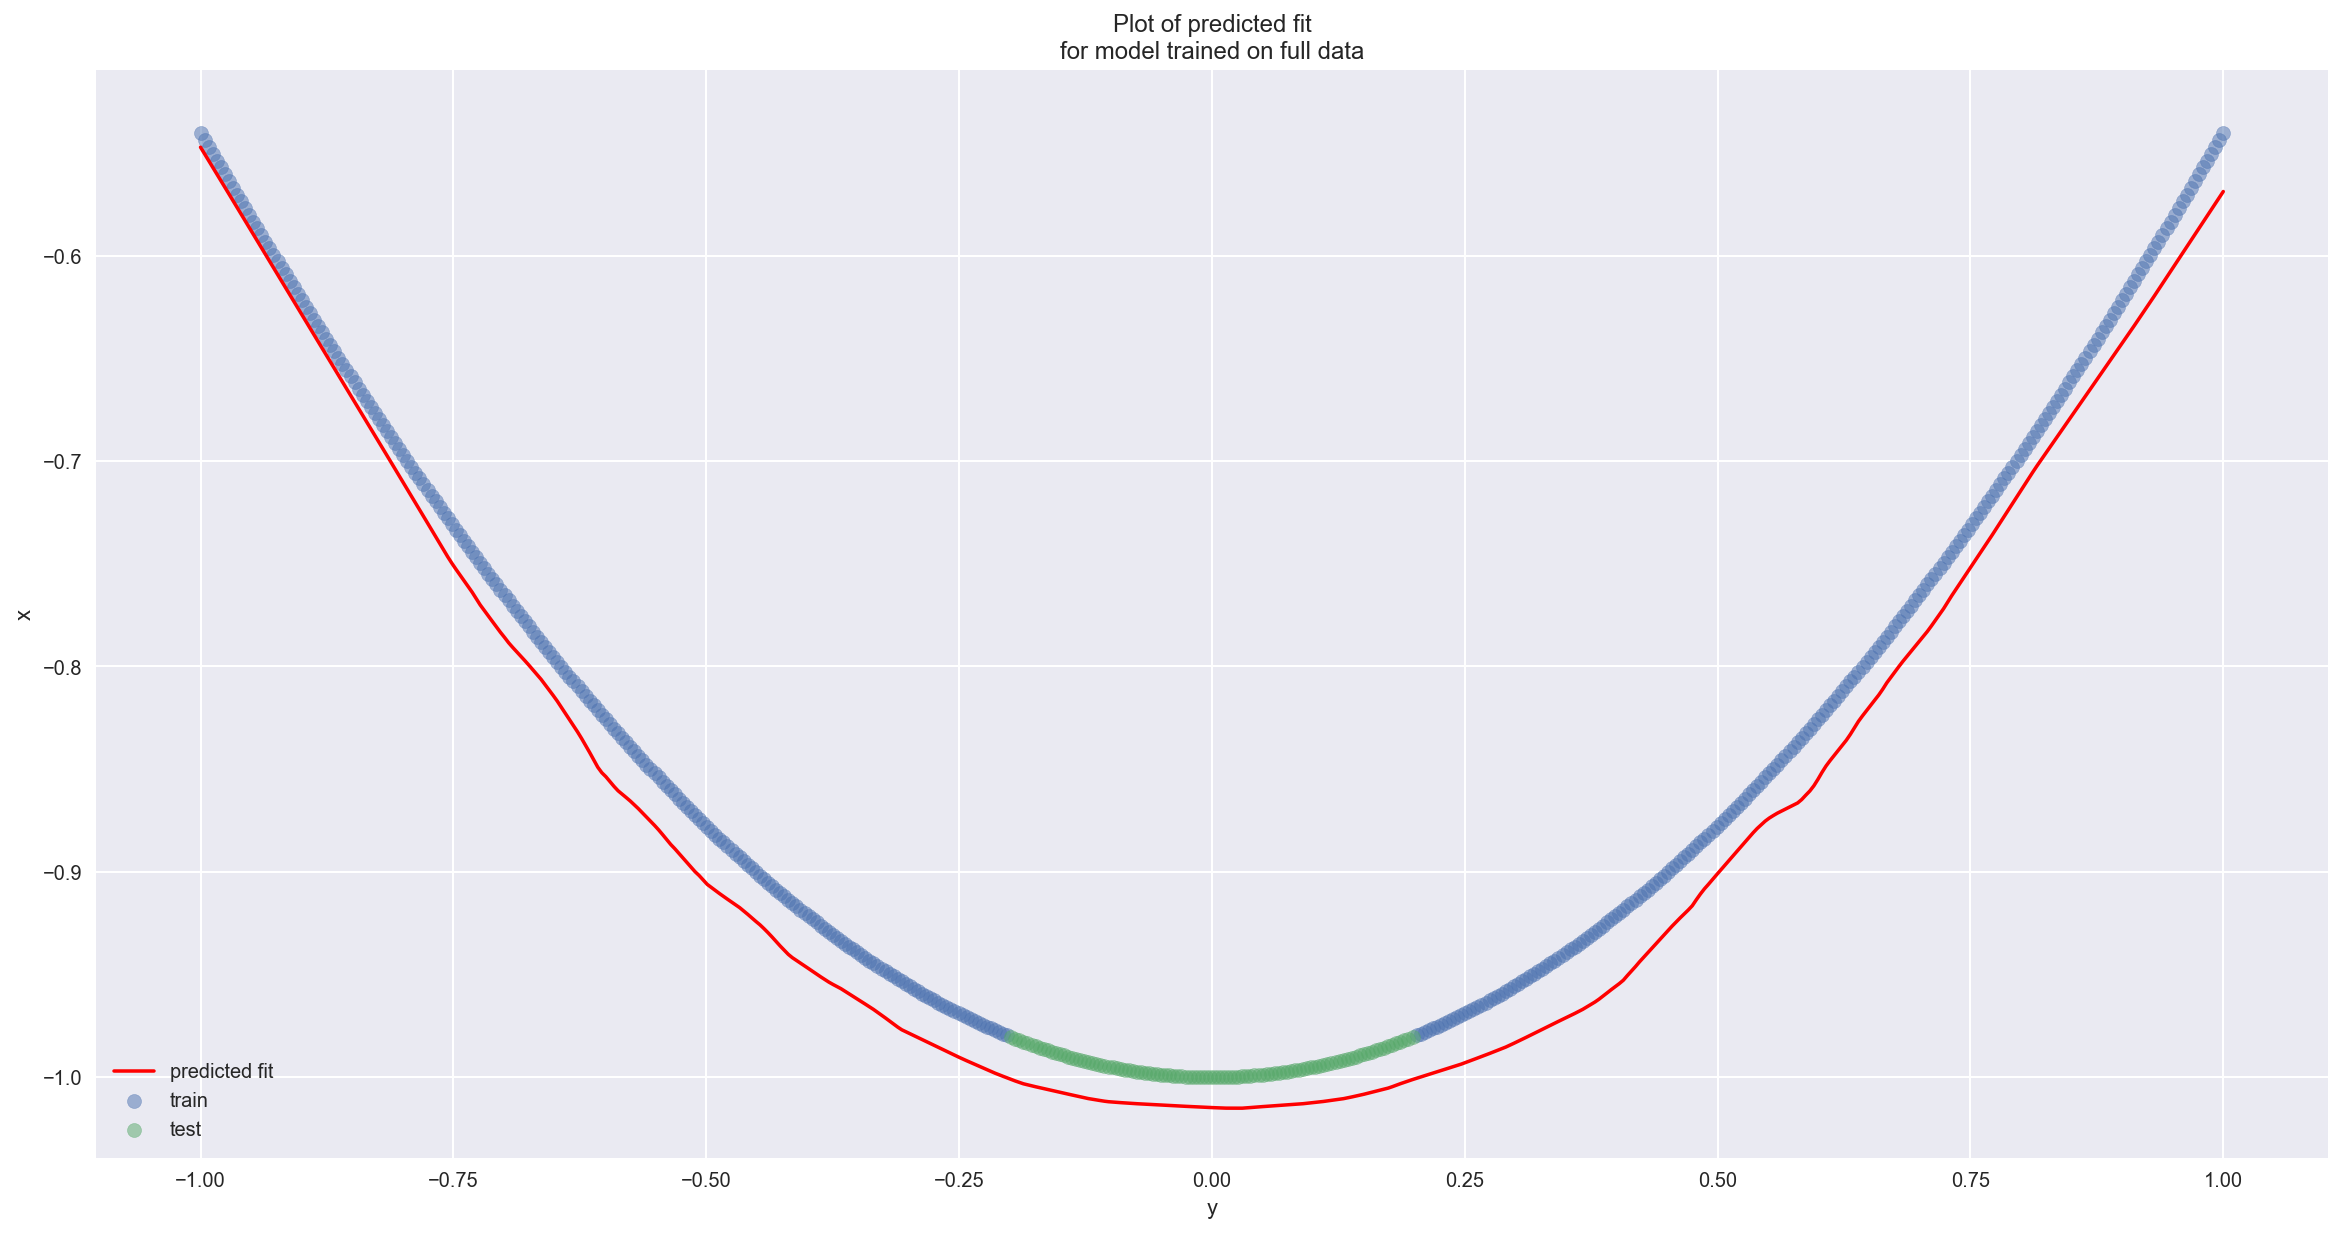

In [54]:
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train', alpha=0.5)
plt.scatter(xs_test, ys_test, label='test', alpha=0.5)
plt.plot(xs, ys_pred, label='predicted fit', c='r')
plt.xlabel('y')
plt.ylabel('x')
plt.title('Plot of predicted fit\nfor model trained on full data')
plt.legend()
plt.show()

## Estimate uncertainty:

In [125]:
# Reformat recorded predictions into a list, where each element is a numpy array
# of the predictions for a given variable from every pass
value_preds = []
for i in range(len(predictions.predhis[0])):
    value_pred_set = []
    for j in range(len(predictions.predhis)):
        value_pred_set.append(np.array(predictions.predhis[j][i]))
    value_preds.append(np.array(value_pred_set))

In [126]:
# Compute the variance for each observation
def ET(tau_inv, yhat):
    return tau_inv + 1 / len(yhat) * np.sum(np.dot(yhat.T, yhat))

def E(yhat):
    return 1 / len(yhat) * np.sum(yhat)

def VAR(tau_inv, yhat):
#     return tau_inv + 1 / len(yhat) * np.sum(np.dot(yhat, yhat.T)) - E(yhat) * E(yhat)
    return tau_inv + 1 / len(yhat) * np.sum([v * v for v in yhat]) - E(yhat) * E(yhat)

# Compute 2 * SD for the data point
def two_SD(tau_inv, yhat):
    return 2 * np.sqrt(VAR(tau_inv, yhat))

N = len(xs)
lambda_val = 5e-7
p = 0.25
l = 1 # Random, user-chosen value
tau_inv = (2 * N * lambda_val) / (p * l**2)

# E(tau_inv, value_preds[0])
# # np.sum(np.dot(value_preds[0].T, value_preds[0]))
# VAR(tau_inv, value_preds[0])

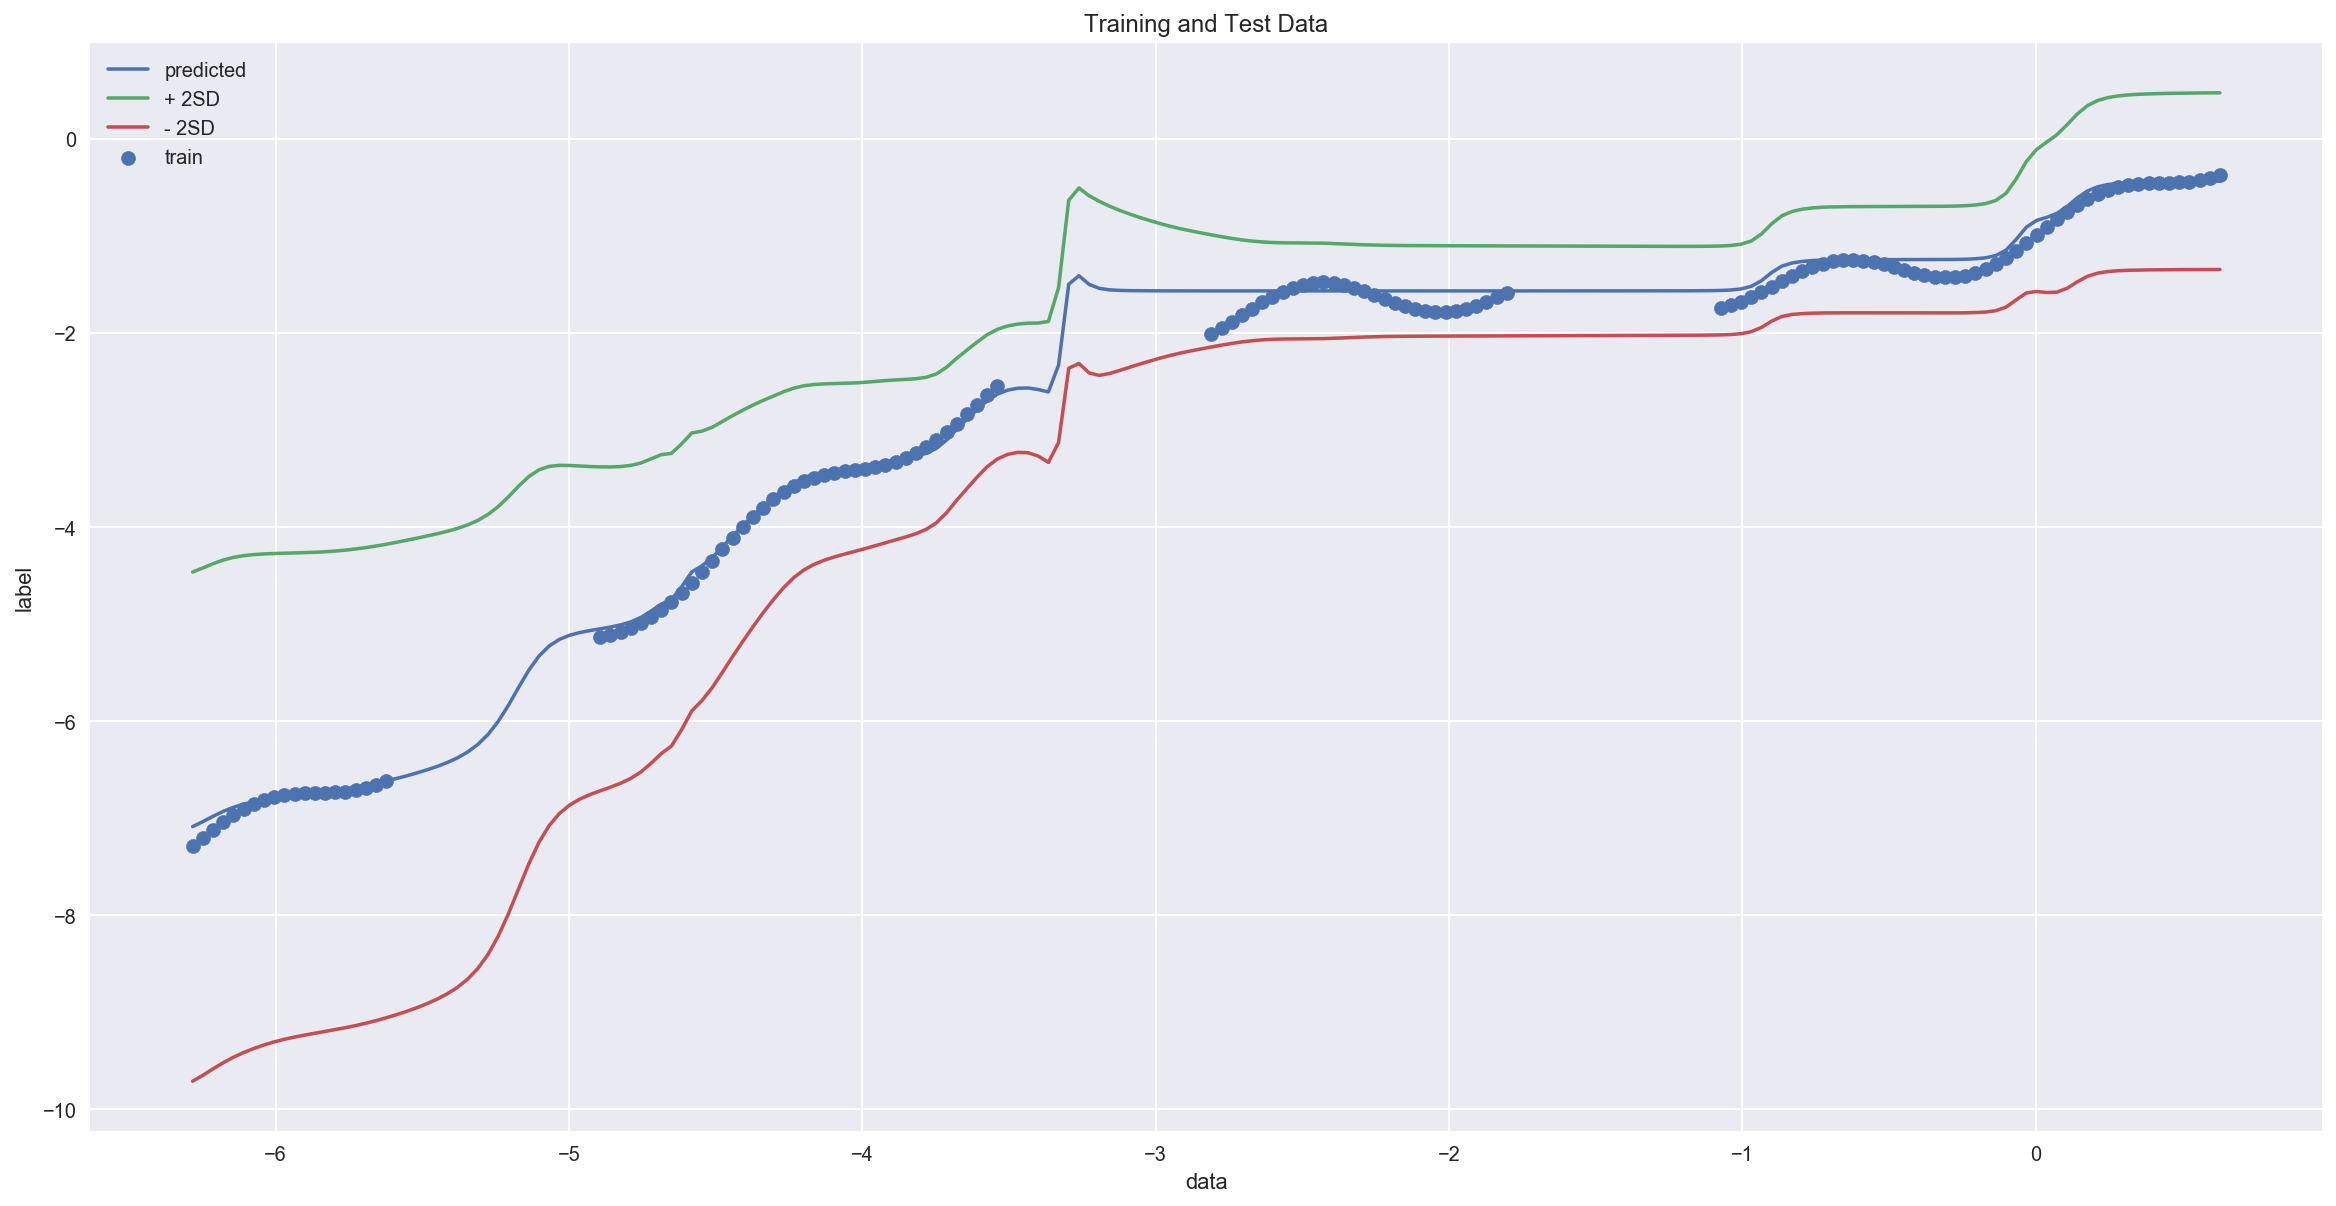

In [128]:
# Plot the predicted vs. actual values# Plot th 
errors = np.zeros(len(value_preds))
for i in range(len(value_preds)):
    errors[i] = two_SD(tau_inv, value_preds[i])

plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train')
#plt.scatter(xs_test, ys_test, label='test')
plt.plot(xs, ys_pred, label='predicted')
plt.plot(xs, ys_pred + errors, label='+ 2SD')
plt.plot(xs, ys_pred - errors, label='- 2SD')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()

-----

## Train the models

### Full data:

In [40]:
# nepochs = 700
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs)*50, num_xs=len(xs))
# callbacks_list = [lrate, out_batch]

# sim_model_full = create_no_test_dropout_model()
# sim_model_full.fit(x=xs, y=ys, epochs=nepochs, batch_size=1, callbacks=callbacks_list, verbose=0)

iteration: 50...  - loss: 0.0284
iteration: 100...  - loss: 0.0202
iteration: 150...  - loss: 0.0178
iteration: 200...  - loss: 0.0163
iteration: 250...  - loss: 0.0149
iteration: 300...  - loss: 0.0139
iteration: 350...  - loss: 0.0131
iteration: 400...  - loss: 0.0129
iteration: 450...  - loss: 0.0123
iteration: 500...  - loss: 0.0116
iteration: 550...  - loss: 0.0115
iteration: 600...  - loss: 0.0111
iteration: 650...  - loss: 0.0107
iteration: 700...  - loss: 0.0102


In [48]:
ys_pred_full = sim_model_full.predict(xs)
ys_pred_full = ys_pred_full[:, 0]

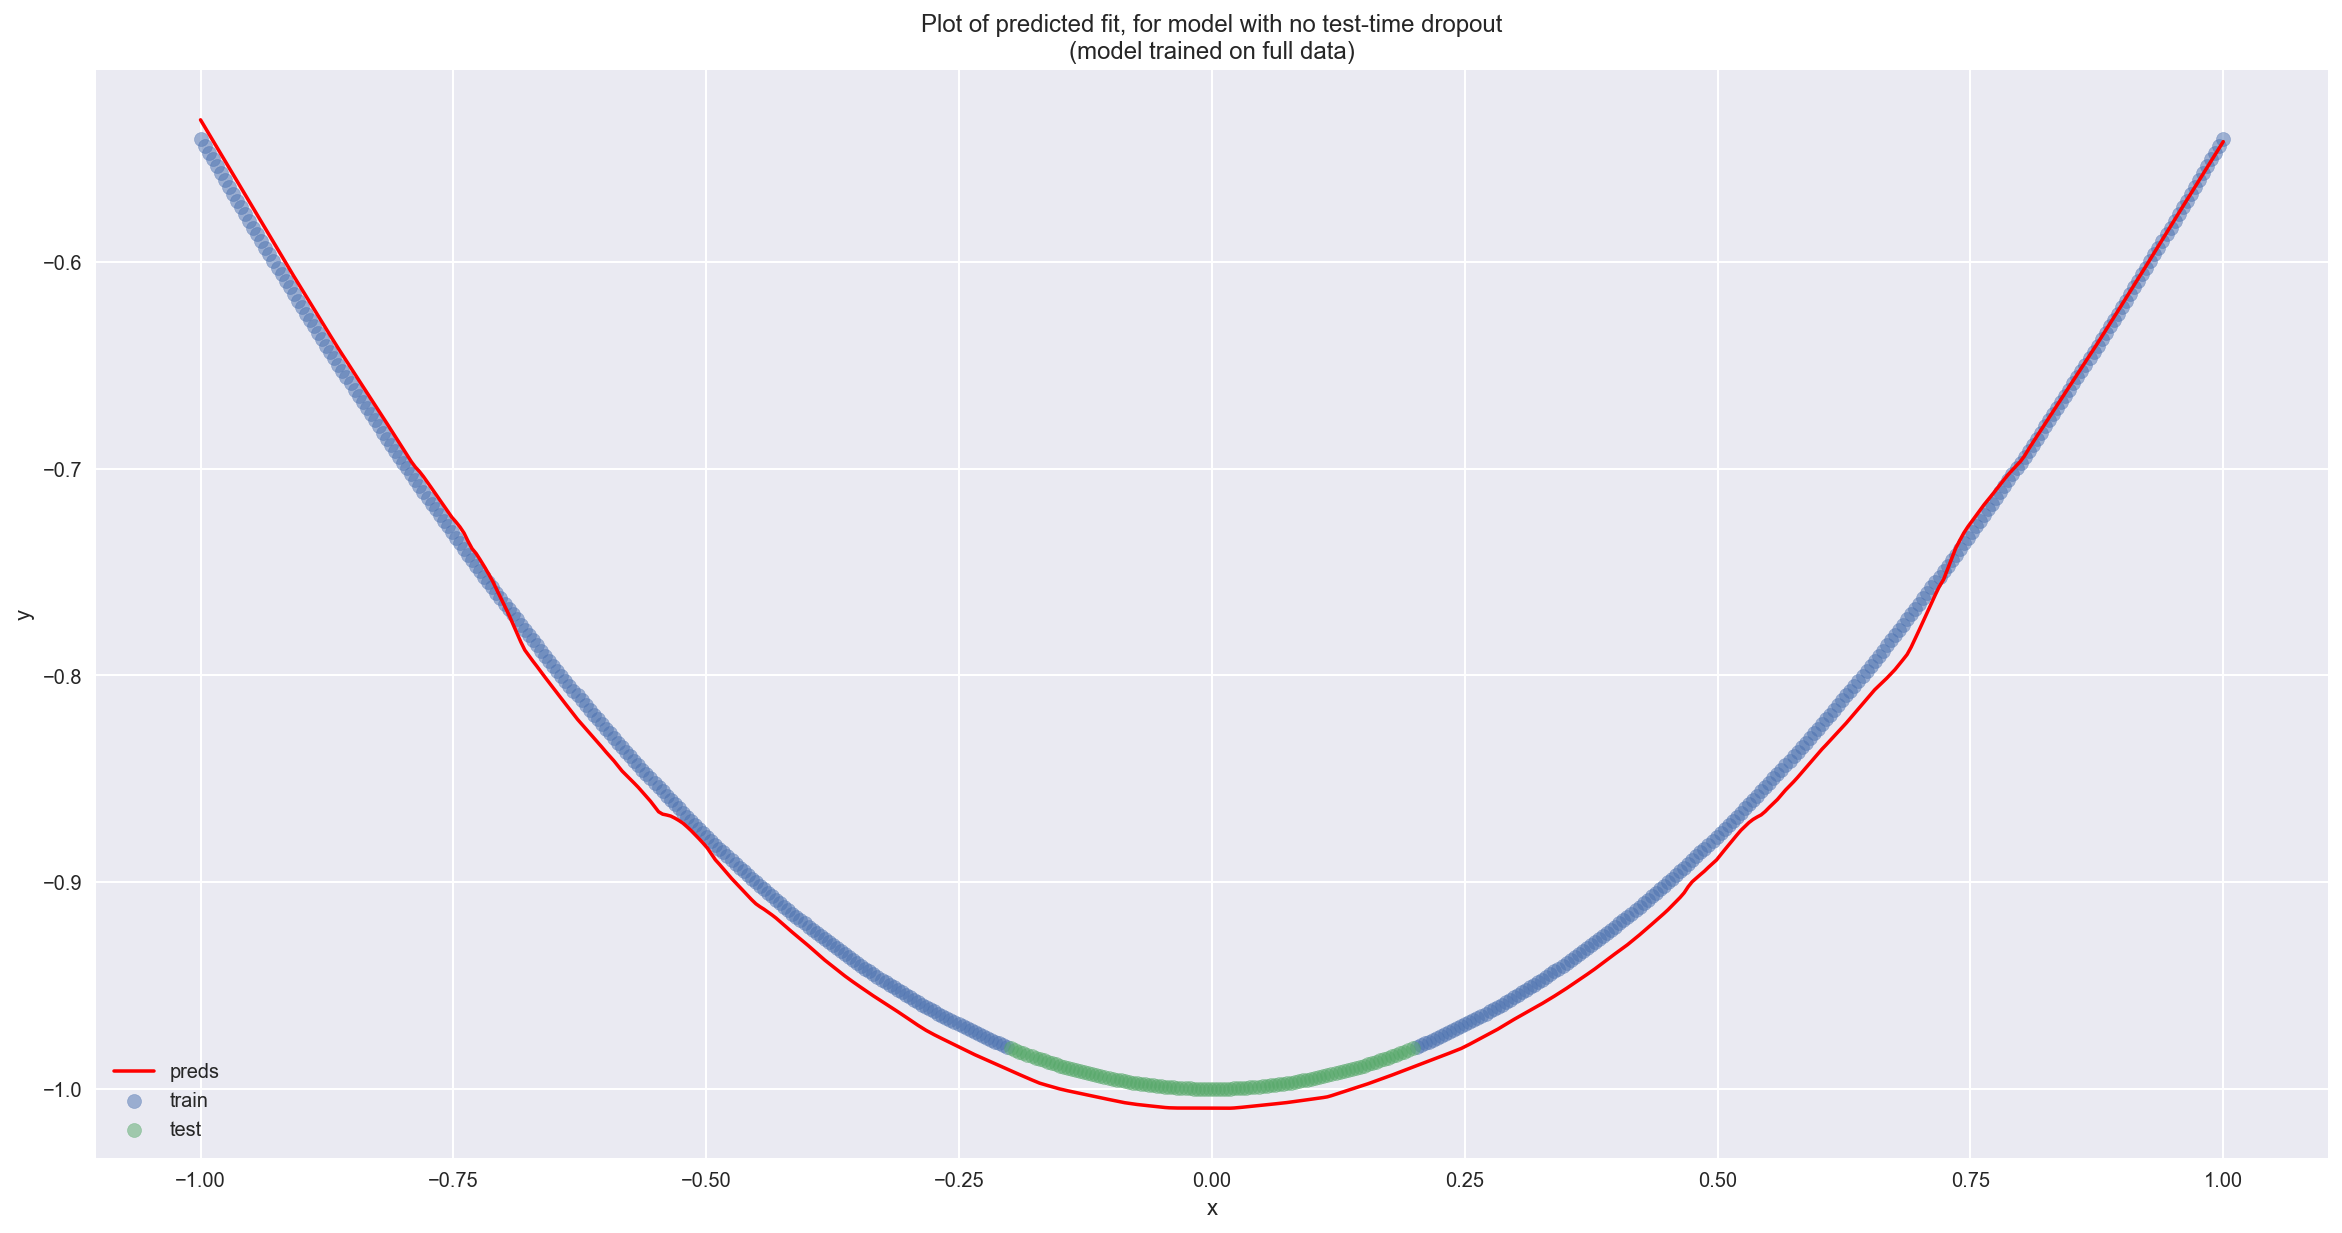

In [58]:
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train', alpha=0.5)
plt.scatter(xs_test, ys_test, label='test', alpha=0.5)
plt.plot(xs, ys_pred_full, label='preds', c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of predicted fit, for model with no test-time dropout\n(model trained on full data)')
plt.legend()
plt.show()

### Training data only

In [44]:
# nepochs = 700
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs_train)*50, num_xs=len(xs_train))
# callbacks_list_train = [lrate, out_batch]

# sim_model_train = create_no_test_dropout_model()
# sim_model_train.fit(x=xs_train, y=ys_train, epochs=nepochs, batch_size=1, callbacks=callbacks_list_train, verbose=0)

iteration: 50...  - loss: 0.0296
iteration: 100...  - loss: 0.0208
iteration: 150...  - loss: 0.0176
iteration: 200...  - loss: 0.0163
iteration: 250...  - loss: 0.0152
iteration: 300...  - loss: 0.0144
iteration: 350...  - loss: 0.0138
iteration: 400...  - loss: 0.0128
iteration: 450...  - loss: 0.0123
iteration: 500...  - loss: 0.0116
iteration: 550...  - loss: 0.0115
iteration: 600...  - loss: 0.0114
iteration: 650...  - loss: 0.0109
iteration: 700...  - loss: 0.0104


In [50]:
ys_pred_train = sim_model_train.predict(xs)
ys_pred_train = ys_pred_train[:, 0]

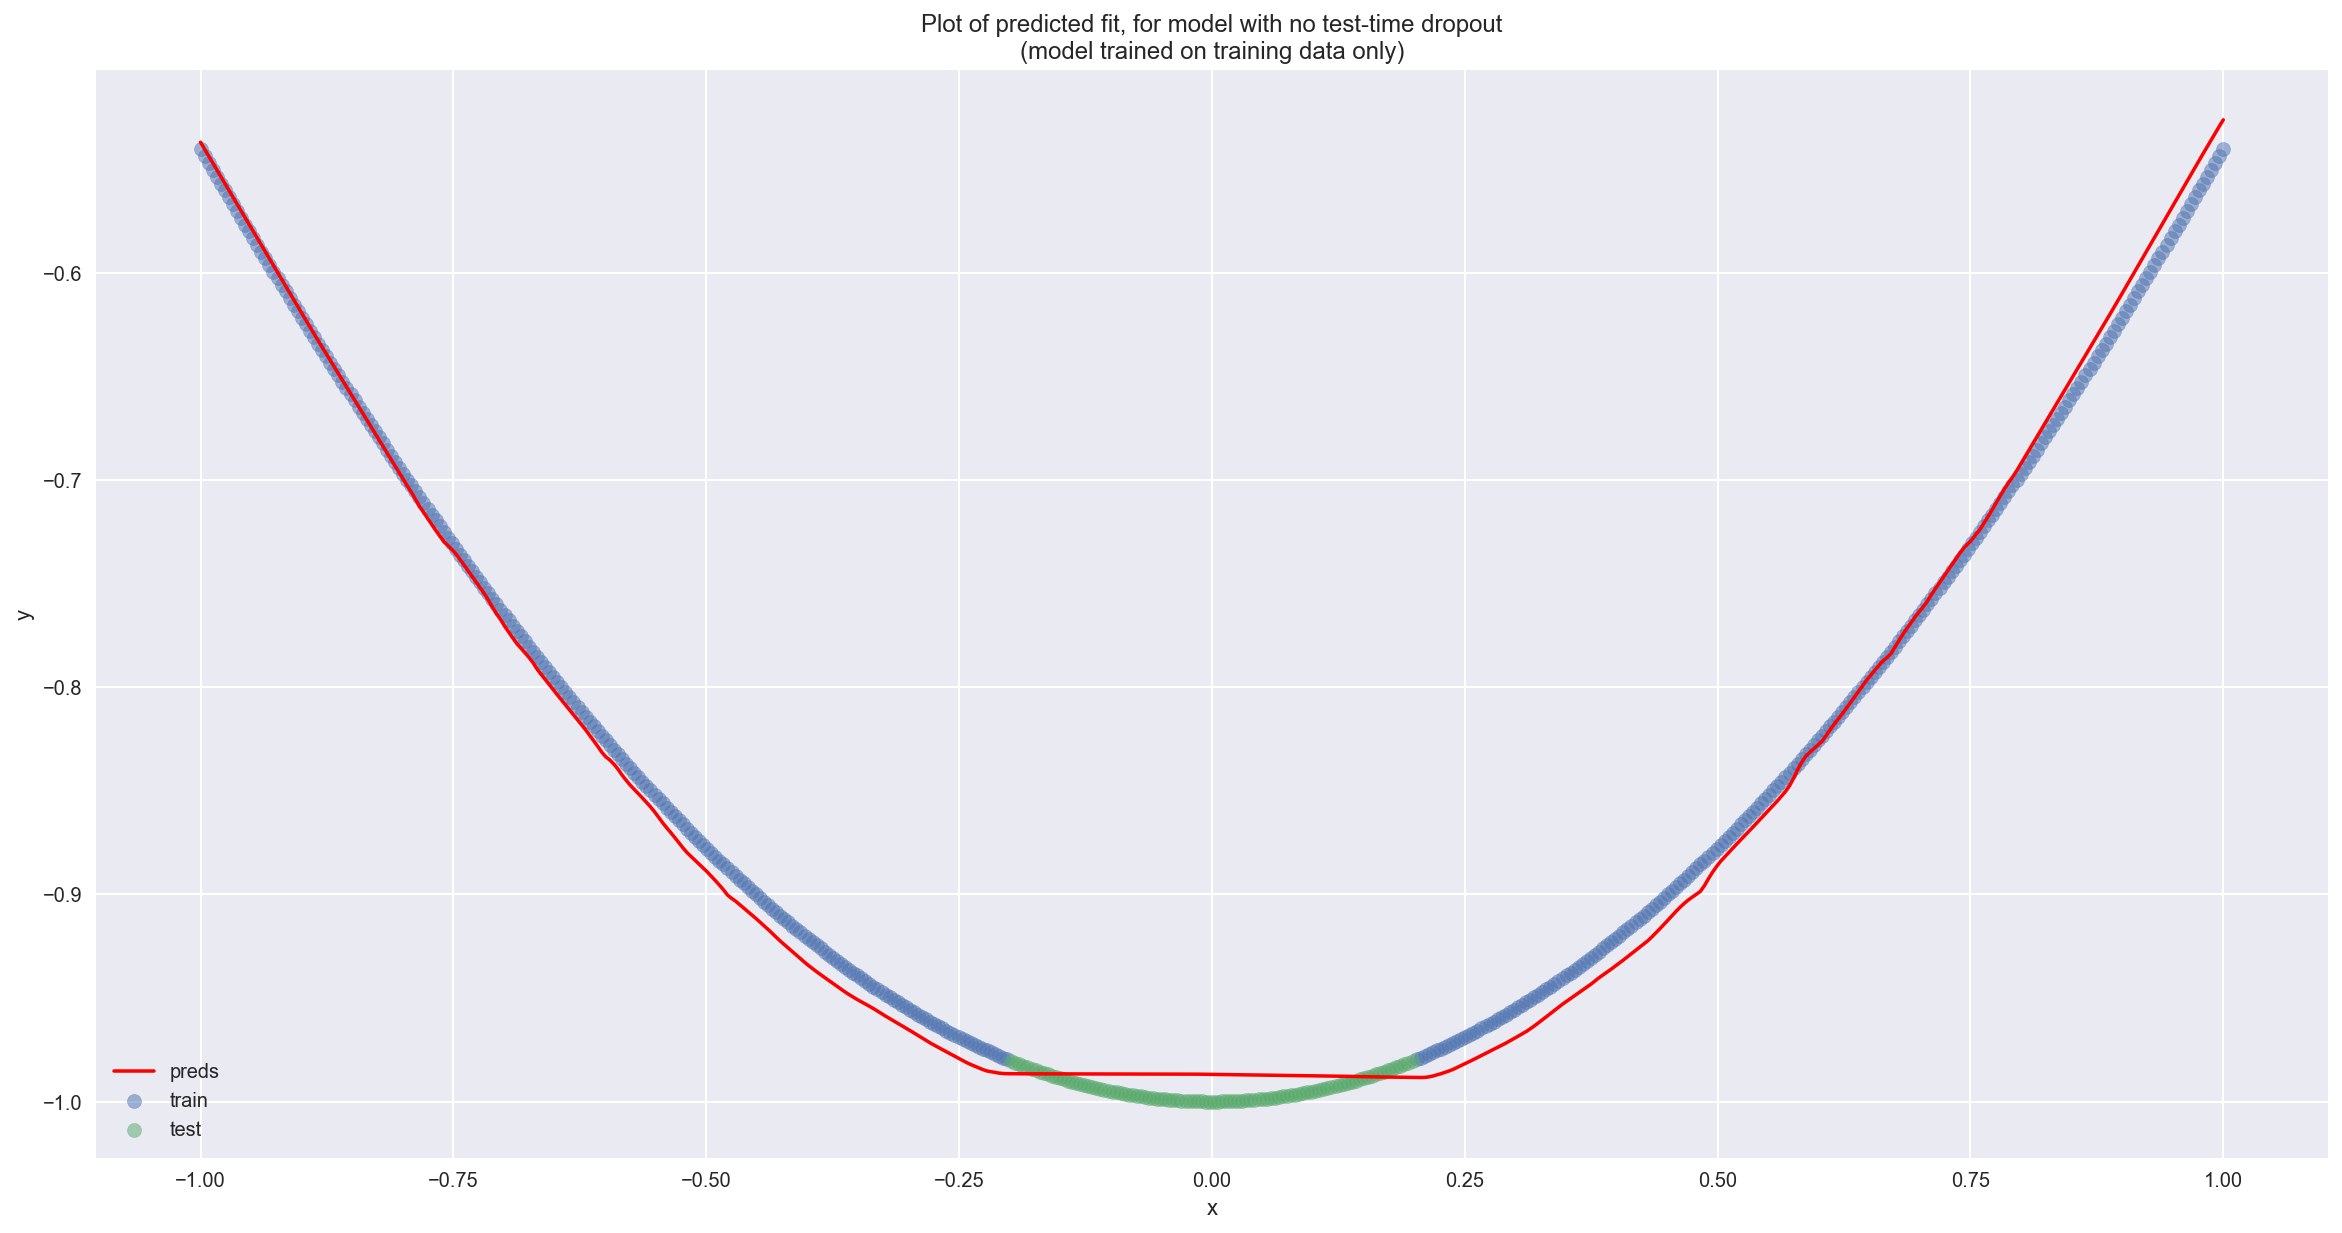

In [59]:
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train', alpha=0.5)
plt.scatter(xs_test, ys_test, label='test', alpha=0.5)
plt.plot(xs, ys_pred_train, label='preds', c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of predicted fit, for model with no test-time dropout\n(model trained on training data only)')
plt.legend()
plt.show()